# GPT MODEL ARCHITECTURE

In [1]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

In [2]:
# Dummy GPT trace the model architecture:
import tiktoken
import torch
import torch.nn as nn

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [3]:
from gpt_dummy import DummyGPTModel

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)


Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


# Layer Normalisation

In [4]:
# Example of a neural network without layer normalisation:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

# calculate mean and variance:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f'{mean=}')
print(f'{var=}')

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
mean=tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var=tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [5]:
# with layer normalisation:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print(out_norm)
print(f"{mean=}")
print(f"{var=}")

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean=tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
var=tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GELU ACTIVATION FUNCTION

In [6]:
import torch.nn as nn
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


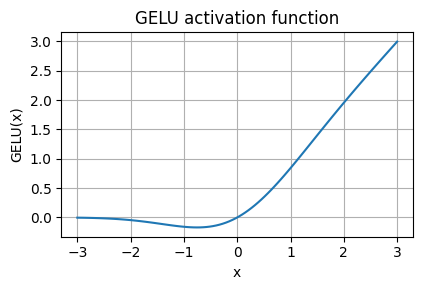

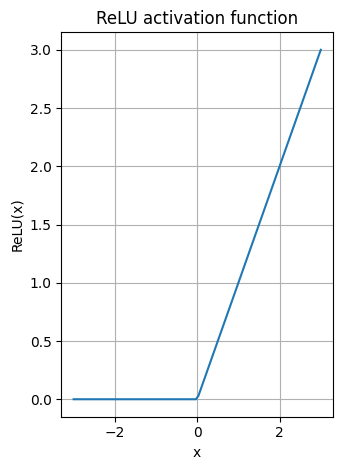

In [7]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100) #A
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Feed forward network


In [8]:
from gpt import FeedForward

ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)


torch.Size([2, 3, 768])


# Short cut/ Residual connections

In [9]:
import torch
import torch.nn as nn

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and layer_output.shape == x.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [10]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])
    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    # Backward pass to calculate the gradients
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


In [11]:
# Without residual connections
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173590746708214
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152042235247791
layers.3.0.weight has gradient mean of 0.0013988739810883999
layers.4.0.weight has gradient mean of 0.00504964729771018


In [12]:
# With connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694102346897125
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


# Tranformer block

In [13]:
from gpt import TransformerBlock
torch.manual_seed(123)

x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

tensor([[[[ 0.9755, -3.3133, -0.1443,  1.7317],
          [ 0.5178, -3.1479,  3.9921,  0.1054],
          [ 2.1150, -1.8031, -0.1007, -1.8556],
          [-5.5577,  0.3575, -1.6647,  0.3256]],

         [[-5.3523,  7.1982, -1.3150,  2.6730],
          [ 7.2249, -3.2465, -0.1557, -0.2570],
          [ 6.0894,  0.9030,  0.3381,  4.8569],
          [-1.8323,  1.0956,  3.2083, -1.4368]],

         [[-0.7987,  0.5056, -2.1760, -0.4728],
          [-1.9262, -0.1537, -5.3686, -0.9209],
          [ 1.6670, -1.5751, -4.0864,  2.2717],
          [-1.7564, -0.0709, -1.4566, -3.3338]],

         [[-1.8932, -0.7422, -0.9122,  2.5591],
          [-3.4902, -0.1443, -0.3035,  0.4030],
          [ 2.5352,  5.3311,  2.1643, -2.0051],
          [ 0.4084, -2.8870,  1.6750,  1.2255]],

         [[-1.5869, -5.8941,  0.5740, -0.3191],
          [-1.3316, -3.4588,  5.5458, -3.5323],
          [ 4.3212,  2.2483,  0.3847, -3.5350],
          [-0.0928,  2.8840, -0.2084,  3.1476]],

         [[-2.4964, -2.9360, -

# GPT Model:

In [14]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

In [15]:
# Create sample data:

import tiktoken
import torch
import torch.nn as nn

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [16]:
# Check output of GPT model:
torch.manual_seed(123)
from gpt import GPTModel

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

tensor([[[[-9.5016e-01, -1.8448e+00,  2.2497e+00,  2.2354e+00],
          [ 4.1319e+00,  3.0590e-01, -4.1366e-01, -2.1695e+00],
          [-4.4848e+00,  9.5192e-01,  6.1092e-01, -1.8153e-01],
          [-2.8657e-01,  1.7790e-01,  5.0122e-01, -2.0204e+00]],

         [[-1.7520e+00,  8.5636e-01, -8.1223e-01, -1.4193e+00],
          [ 4.6492e+00, -2.7599e+00, -1.7757e+00,  2.6612e+00],
          [ 1.1534e+00,  1.5699e+00,  3.8418e-01, -1.0881e-01],
          [-2.0622e+00, -3.2506e+00,  1.2508e-01,  1.1016e+00]],

         [[ 2.1146e+00,  2.7662e+00, -4.9324e-01, -4.3137e+00],
          [-3.3048e+00, -3.0260e-01,  4.5475e-01, -2.2042e+00],
          [-4.0125e+00, -2.0699e+00,  3.0089e+00, -1.5453e+00],
          [-2.6489e-01, -6.2558e-02, -3.7323e+00, -3.8743e+00]],

         [[ 5.8461e-01, -5.6263e+00, -1.1446e+00, -7.8638e-01],
          [ 1.1845e+00, -1.1965e+00,  3.6195e+00, -2.4835e+00],
          [-1.5325e+00,  5.6252e-01,  1.9819e+00, -2.2648e+00],
          [-1.0057e+00, -1.1031e+0

In [17]:
# Analyse model:
total_param = sum(p.numel() for p in model.parameters())
print(total_param)

163009536


In [20]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [21]:
total_size_bytes = total_param * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")


Total size of the model: 621.83 MB
